##1. Importamos librerías y montamos drive

In [2]:
# Tensorflow and tf.keras
import tensorflow as tf
from tensorflow import keras


#Helper libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import initializers
from keras.utils.vis_utils import plot_model
from keras.layers import BatchNormalization, Dropout
from keras.layers.core import Activation
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping
import pickle
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##1.1Establecemos el path del drive

In [3]:
path = "/content/drive/MyDrive/Deep_Learning-UPM/Práctica-1.1/"

##3. Cargamos los datos ya preprocesados

In [4]:
datos_limpios_x = pd.read_csv(path + 'FootballPlayerPreparedCleanAttributes.csv')
datos_limpios_y = pd.read_csv(path + 'FootballPlayerOneHotEncodedClasses.csv')

print(datos_limpios_x.shape, datos_limpios_y.shape)
datos_limpios_x[:5], datos_limpios_y[:5]

(16122, 17) (16122, 4)


(   Crossing  HeadingAccuracy  ShortPassing  ...  Positioning    Vision  Composure
 0  0.268293         0.139241      0.013699  ...     0.190476  0.097561   0.081081
 1  0.000000        -0.493671      0.178082  ...     0.000000  0.121951   0.000000
 2 -0.048780        -0.265823     -0.041096  ...    -0.095238  0.219512   0.000000
 3  0.048780        -0.417722     -0.013699  ...    -0.166667  0.024390  -0.297297
 4  0.073171         0.063291     -0.095890  ...     0.119048  0.048780  -0.405405
 
 [5 rows x 17 columns],    Poor:[46.0, 62.0]  ...  Excel:[72.0, 94.0]
 0                0.0  ...                 0.0
 1                1.0  ...                 0.0
 2                1.0  ...                 0.0
 3                0.0  ...                 0.0
 4                1.0  ...                 0.0
 
 [5 rows x 4 columns])

##4. División de datos


1.   80% Entrenamiento
2.   10% Desarrollo
3.   10% Test



In [5]:
train = int(datos_limpios_x.shape[0]*0.8)
test = dev = int((datos_limpios_x.shape[0]-train)/2)

train_x = datos_limpios_x[:train]
train_y = datos_limpios_y[:train]

dev_x   = datos_limpios_x[train:train+dev]
dev_y   = datos_limpios_y[train:train+dev]

print('Entrenamiento : train_x: ', train_x.shape, ' | train_y: ', train_y.shape)
print('Desarrollo    : dev_x:   ', dev_x.shape, ' | dev_y:    ', dev_y.shape)

Entrenamiento : train_x:  (12897, 17)  | train_y:  (12897, 4)
Desarrollo    : dev_x:    (1612, 17)  | dev_y:     (1612, 4)


##5.Establecemiento de hiperparámetros

5.1-Creamos carpeta para guardar un informe de el modelo

In [6]:
import os

dir_name = "prueba_828"
res_path = path + "Modelos/1Yanguas/" + dir_name + "/"
if not os.path.isdir(res_path):
  os.mkdir(res_path)
  print("Created")
else:
  print("Dir already exists")

Created


5.2-Establecemos la configuración del modelo

In [7]:
#Hiperparametros
nombre_modelo = dir_name
n_epochs = 1000
learning_rate = 0.1
batch_size = 512

#Parametros del modelo
n_neurons_per_hlayer = [500, 250, 75, 25]
act_ints = ['elu', 'elu', 'elu', 'elu']
act_out = 'softmax'
dropout = 0.2
BatchN  = 1
L2      = '0.001'

#otros
verbose = 0
patience = 100

5.3-Guardamos en un DF la config y volcamos en excel

In [8]:
data = {'Epocas': n_epochs, 
        'LR' : learning_rate,
        'Batch' : batch_size, 
        'Neuronas_por_capa' : '[' + ", ".join([str(i) for i in n_neurons_per_hlayer]) + ']',
        'act_int' : '[' + ", ".join(act_ints) + ']', 
        'act_out': act_out,
        'Dropout': str(dropout), 
        'BatchNormalization': BatchN,
        'L2': L2}

df_model_conf = pd.DataFrame(data, index = [0])
df_model_conf.index = [str(nombre_modelo)]


df_model_conf.to_excel(res_path + 'model_conf.xlsx', index=True)

##6.Construcción del modelo
Inicializadores recomendados:


1.   **RELU** --> **He** o uniforme o normal
2.   **SELU** --> **LeCun**
2.   **Sigmoid, Tanh, Softmax o no activación** --> **Xavier** tambien llamada **GlorotNormal**



In [9]:
INPUTS  = train_x.shape[1]
OUTPUTS = train_y.shape[1]


def construir_modelo(inputs=INPUTS, outputs=OUTPUTS, n_neurons_per_hlayer=n_neurons_per_hlayer):
  model = keras.Sequential(name="DeepFeedforward")
  model.add(keras.layers.InputLayer(input_shape=(INPUTS,), batch_size=None))

  for neurons, act in zip(n_neurons_per_hlayer, act_ints):
    if BatchN == 1:
      if L2 != '':          
        model.add(keras.layers.Dense(neurons, kernel_initializer=keras.initializers.he_uniform(seed=1), use_bias=False, kernel_regularizer=keras.regularizers.l2(float(L2))))
        model.add(BatchNormalization())
      else:
        model.add(keras.layers.Dense(neurons, kernel_initializer=keras.initializers.he_uniform(seed=1), use_bias=False))
        model.add(BatchNormalization())
    else:
      if L2 != '':  
        model.add(keras.layers.Dense(neurons, kernel_initializer=keras.initializers.he_uniform(seed=1), use_bias=True, kernel_regularizer=keras.regularizers.l2(float(L2))))
      else:
        model.add(keras.layers.Dense(neurons, kernel_initializer=keras.initializers.he_uniform(seed=1), use_bias=True))

    model.add(Activation(act))
    model.add(Dropout(rate=dropout))

  model.add(keras.layers.Dense(OUTPUTS, activation="softmax", kernel_initializer=tf.keras.initializers.GlorotNormal(seed=1)))

  model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
              metrics=["categorical_accuracy"])
  
  return model


modelo = construir_modelo()
modelo.summary()
#plot_model(modelo, show_shapes=True, show_layer_names=True)

Model: "DeepFeedforward"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 500)               8500      
                                                                 
 batch_normalization (BatchN  (None, 500)              2000      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 500)               0         
                                                                 
 dropout (Dropout)           (None, 500)               0         
                                                                 
 dense_1 (Dense)             (None, 250)               125000    
                                                                 
 batch_normalization_1 (Batc  (None, 250)              1000      
 hNormalization)                                   

##7.Entrenamiento del modelo

In [10]:
import time

path_checkpoint = res_path + nombre_modelo + ".h5"


early_stopping = EarlyStopping(monitor='val_categorical_accuracy', 
                               patience = patience, 
                               restore_best_weights=True
)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_categorical_accuracy",
    filepath=path_checkpoint,
    save_weights_only=True,
    save_best_only=True,
    verbose=0
)

ini = time.perf_counter()

history = modelo.fit(
    train_x,
    train_y,
    batch_size=batch_size,
    epochs=n_epochs,
    validation_data=(dev_x, dev_y),
    callbacks=[early_stopping, modelckpt_callback],
    verbose = verbose
)

fin = time.perf_counter()
tiempo_entreno = round(fin-ini,3)
print('Tiempo de entreno (s):' ,tiempo_entreno)

Tiempo de entreno (s): 80.136


###7.1 Guardado del modelo y el historial de entramiento

In [11]:
modelo.save(path_checkpoint)
with open(res_path + nombre_modelo + "history", 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

##8. Evaluación del modelo sobre conjunto de desarrollo

Accuracy for the training set:           0.799
Accuracy for the development test set:   0.83
Train error:                             0.526
Dev error:                               0.521
Human error:                             0.1
Bias (Loss - Human Error):               0.426
Variance (Val_loss - Loss):              0.005
Time:                                    80.136 sec


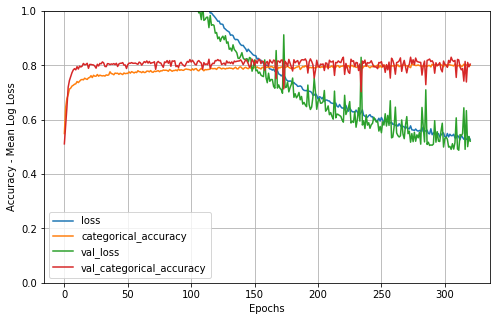

In [12]:
results=pd.DataFrame(history.history)

max_index = results.val_categorical_accuracy.idxmax()
dev_accuracy = results.val_categorical_accuracy[max_index]
train_accuracy = results.categorical_accuracy[max_index]

human_err = 0.1
train_err = round(results.loss[len(results.loss) - 1], 3)
dev_err = round(results.val_loss[len(results.val_loss) - 1], 3)
print(f"{'Accuracy for the training set:' : <40} {round(train_accuracy, 3)}")
print(f"{'Accuracy for the development test set:' : <40} {round(dev_accuracy, 3)}")
print(f"{'Train error:' : <40} {train_err}")
print(f"{'Dev error:' : <40} {dev_err}")
print(f"{'Human error:' : <40} {human_err}")
print(f"{'Bias (Loss - Human Error): ' : <40} {round(train_err - human_err, 3)}")
print(f"{'Variance (Val_loss - Loss): ' : <40} {abs(round(dev_err - train_err, 3))}")
print(f"{'Time:' : <40} {round(fin - ini, 3)} sec")

data = {'train_accuracy': round(results.categorical_accuracy.values[-1:][0], 3), 
        'dev_accuracy' : round(results.val_categorical_accuracy.values[-1:][0], 3),
        'train_err' : train_err, 
        'dev_err' : dev_err,
        'human_err' : human_err, 
        'bias': round(train_err - human_err, 3),
        'variance': abs(round(dev_err - train_err, 3)), 
        'time (sec)': round(fin - ini, 3)}
    
df_model_conf = pd.DataFrame(data, index = [0])
df_model_conf.index = [str(nombre_modelo)]

df_model_conf.to_excel(res_path + 'model_res.xlsx', index=True)

results.plot(figsize=(8, 5))
plt.grid(True)
plt.xlabel ("Epochs")
plt.ylabel ("Accuracy - Mean Log Loss")
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.savefig(res_path + 'error_plot.png')
plt.show()

##9. Evaluacion del modelo sobre el conjunto de test

###9.1.Cargamos los datos del test final

In [13]:
test_x = datos_limpios_x[train+dev:]
test_y = datos_limpios_y[train+dev:]
print ("test_x:",test_x.shape)
print ("test_y:",test_y.shape)

test_x: (1613, 17)
test_y: (1613, 4)


###9.2.Precisión del modelo para el test final

In [14]:
y_test_pred_prob = modelo.predict(test_x).round(2)
y_test_pred = np.argmax(y_test_pred_prob, 1)
y_test_pred_prob, len(y_test_pred_prob), y_test_pred, len(y_test_pred)

y_test = np.argmax(test_y.values, 1)
y_test, y_test_pred

(array([3, 1, 0, ..., 0, 0, 2]), array([3, 0, 1, ..., 0, 0, 2]))

###9.4-Obtenemos un informe del clasificador

In [15]:
from sklearn.metrics import classification_report
target_names = ['Pobre', 'Intermedio', 'Bueno', 'Excelente']
informe = classification_report(y_test, y_test_pred, target_names=target_names, digits=3)
print(classification_report(y_test, y_test_pred, target_names=target_names, digits=3))

informe = classification_report(y_test, y_test_pred, target_names=target_names, digits=3, output_dict=True)
df_informe = pd.DataFrame(informe).transpose()

df_informe.to_excel(res_path + 'informe.xlsx', index=True)

              precision    recall  f1-score   support

       Pobre      0.843     0.905     0.873       402
  Intermedio      0.703     0.701     0.702       405
       Bueno      0.776     0.750     0.763       452
   Excelente      0.906     0.870     0.888       354

    accuracy                          0.803      1613
   macro avg      0.807     0.807     0.806      1613
weighted avg      0.803     0.803     0.802      1613



###9.5-Obtenemos una matriz de correlación para ver el número de bien y mal clasificados**

Precision media sobre el conjunto de test:  0.8068


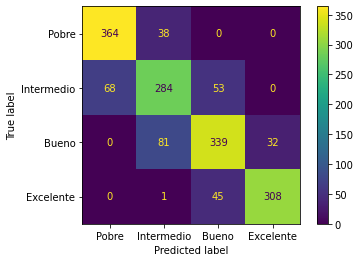

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score

target_names_n = [0, 1, 2, 3]

cm = confusion_matrix(y_test, y_test_pred, labels=target_names_n)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,  display_labels=target_names)
disp.plot()
plt.savefig(res_path + "cm.png")
print('Precision media sobre el conjunto de test: ', round(precision_score(y_test, y_test_pred, average='macro'),4))
plt.show()